<a href="https://colab.research.google.com/github/Jhsysng/AI_Model_Sec/blob/main/AI_vuln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.setrecursionlimit(10**5)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install adversarial-robustness-toolbox
!pip install keras_tuner
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 55.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras_tuner as kt
from keras.layers import InputLayer, Dense, Conv2D, BatchNormalization, Dropout, Flatten, LeakyReLU, MaxPool2D
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier
#tf.compat.v1.disable_eager_execution()

In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/dataset/chineseMNIST.csv')

In [6]:
X = dataset.iloc[:,:-2]
y = dataset.iloc[:,-2]

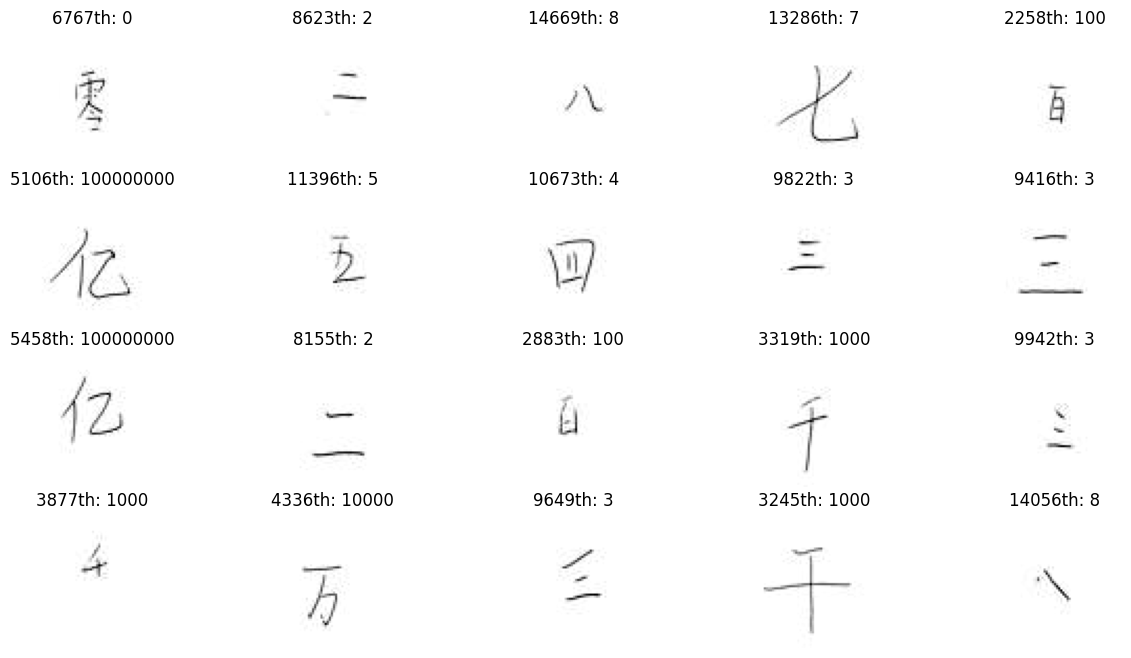

In [7]:
plt.figure(figsize=(15,8))

for i in range(20):
  plt.subplot(4,5,i+1)

  img_xy = np.random.randint(len(X))
  img = X.iloc[img_xy,:].to_numpy().reshape(64,64)
  plt.title(f"{img_xy}th: {y[img_xy]}", fontsize=12)
  plt.axis('off')
  plt.imshow(img, cmap='binary')
plt.show()

In [8]:
X.iloc[0,:].to_numpy().reshape(64,64).shape

(64, 64)

In [9]:
X = X.values    # serires to numpy
X = X.reshape((15000,64,64))
X_scaled = X/255.0
X_scaled = X_scaled[:,:,:,np.newaxis]
le = LabelEncoder()
y = le.fit_transform(y)
classes = le.classes_

In [10]:
X_scaled[0].shape

(64, 64, 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [12]:
def create_model(hp):
    model = keras.models.Sequential()
    model.add(InputLayer(input_shape=(64,64,1)))
    model.add(Conv2D(hp.Int("input_units",32,128,32),3,padding='same',activation='relu'))   # 
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    drop = hp.Choice('Dropout_rate',values=[0.1,0.2,0.3])
    model.add(Dropout(drop))
    
    for i in range(hp.Int('number_of_layers',1,3,1)):
        model.add(Conv2D(hp.Int("input_units1",64,256,32),3,padding='same',activation='relu'))

    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Flatten())
    model.add(Dense(hp.Int('input_units2',512,1024,128),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Dense(15))

    loss = SparseCategoricalCrossentropy(from_logits=True)
    opt = Adam(hp.Choice('lr',values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

    return model

In [13]:
tf.compat.v1.disable_eager_execution()
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='chinese_vuln')

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=40, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 02m 23s]
val_accuracy: 0.9804166555404663

Best val_accuracy So Far: 0.9858333468437195
Total elapsed time: 00h 47m 58s


In [15]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [16]:
model = tuner.hypermodel.build(best_hps)

In [17]:
classifier=KerasClassifier(model=model,use_logits=False)

In [18]:
classifier.fit(X_train, y_train, batch_size=16,nb_epochs=9 )

Train on 12000 samples
Epoch 1/9
12000/12000 [==============================] - 32s 3ms/sample - loss: 0.7709 - accuracy: 0.7665
Epoch 2/9
12000/12000 [==============================] - 30s 2ms/sample - loss: 0.1824 - accuracy: 0.9437
Epoch 3/9
12000/12000 [==============================] - 29s 2ms/sample - loss: 0.1141 - accuracy: 0.9648
Epoch 4/9
12000/12000 [==============================] - 29s 2ms/sample - loss: 0.0650 - accuracy: 0.9803
Epoch 5/9
12000/12000 [==============================] - 30s 2ms/sample - loss: 0.0498 - accuracy: 0.9858
Epoch 6/9
12000/12000 [==============================] - 29s 2ms/sample - loss: 0.0423 - accuracy: 0.9870
Epoch 7/9
12000/12000 [==============================] - 30s 3ms/sample - loss: 0.0306 - accuracy: 0.9908
Epoch 8/9
12000/12000 [==============================] - 30s 3ms/sample - loss: 0.0369 - accuracy: 0.9883
Epoch 9/9
12000/12000 [==============================] - 30s 2ms/sample - loss: 0.0214 - accuracy: 0.9940


In [31]:
rnd_idx = np.random.randint(0,len(X_test),1000)
y_pred = classifier.predict(X_test[rnd_idx])
y_true = y_test[rnd_idx]

In [40]:
accuracy=np.sum(np.argmax(y_pred, axis=1)==y_true)/len(y_true)
print(accuracy*100)

0.988

In [41]:
y_pred_idx = np.array(list(map(lambda x: np.argmax(x),y_pred)))

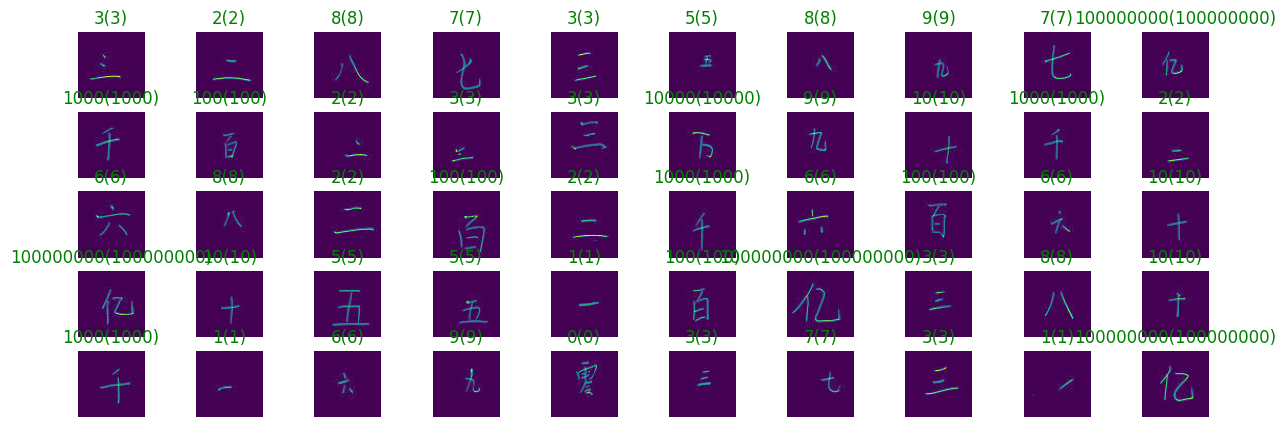

In [46]:
plt.figure(figsize=(15,5))

for i in range(50):
  plt.subplot(5,10,i+1)
  plt.title(f'{classes[y_true[i]]}({classes[y_pred_idx[i]]})',
            color=("green" if y_true[i]==y_pred_idx[i] else "red"))
  plt.axis('off')
  plt.imshow(X_test[rnd_idx[i]].reshape(64,64) * 255.0)
plt.show()

#Adversial Attack
##FGSM

In [62]:
from art.attacks.evasion import FastGradientMethod
attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv = attack.generate(x=X_test)

In [63]:
y_pred_fgsm = classifier.predict(x_test_adv)
atk_accuracy = np.sum(np.argmax(y_pred_fgsm, axis=1)==y_test)/len(y_test)
print(atk_accuracy*100)

6.9


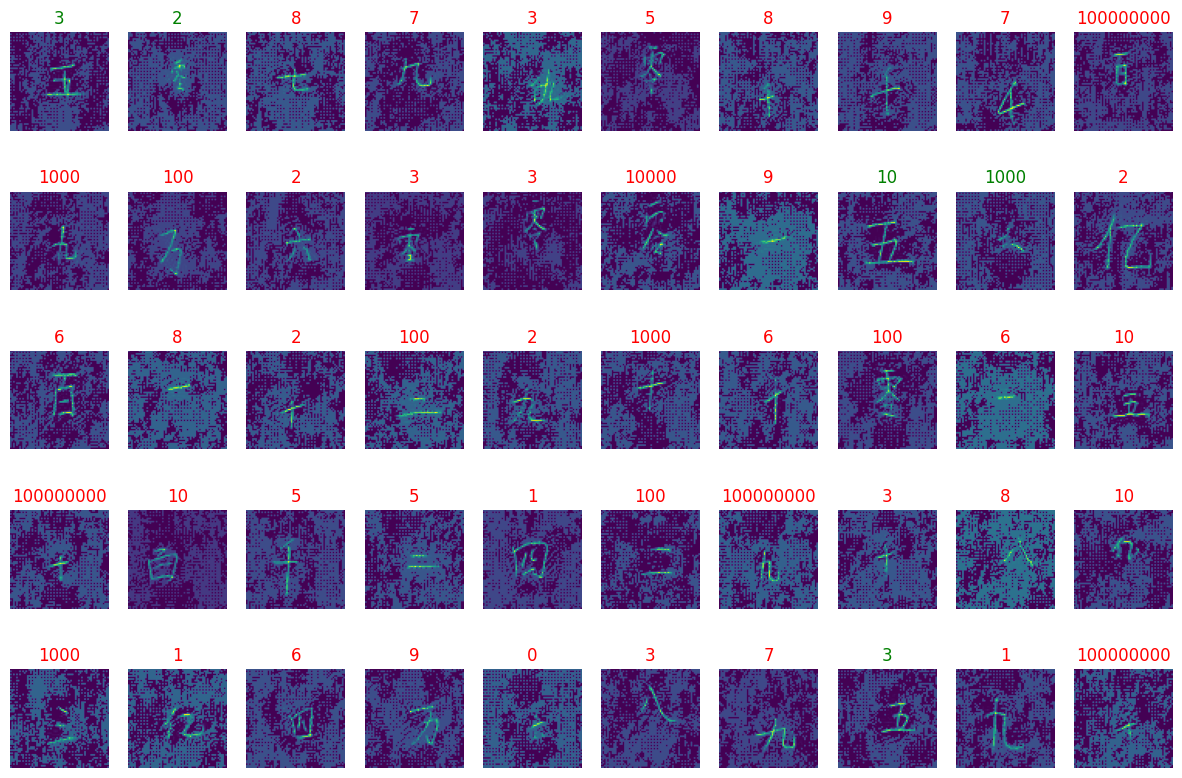

In [64]:
y_pred_fgsm = np.array(list(map(lambda x:np.argmax(x), y_pred_fgsm)))
plt.figure(figsize=(15,10))

for i in range(50):
  plt.subplot(5,10,i+1)
  plt.title(f'{classes[y_true[i]]}', color=("green" if y_test[i]==y_pred_fgsm[i] else "red"))
  plt.axis('off')
  plt.imshow(x_test_adv[i].reshape(64,64)*255.0)
plt.show()

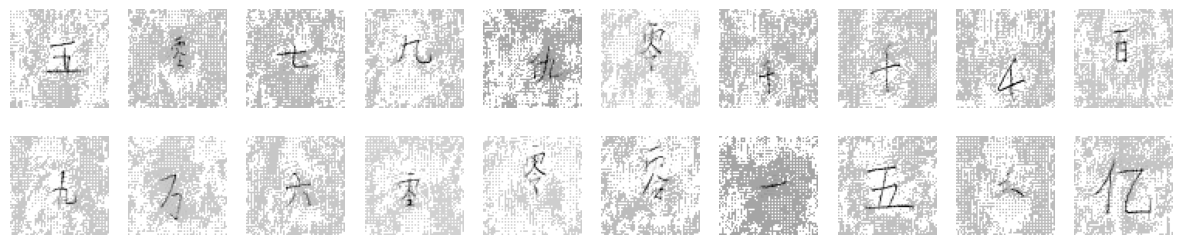

In [65]:
plt.figure(figsize=(15,8))

for i in range(20):
  plt.subplot(5,10,i+1)
  plt.axis('off')
  plt.imshow(x_test_adv[i].reshape(64,64)*255.0, cmap='binary')
plt.show()

##PGD

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

atk_model = ProjectedGradientDescent(estimator=classifier, eps=0.3)
x_test_atk = atk_model.generate(x=X_test)

In [ ]:
plt.figure(figsize=(15,8))

for i in range(20):
  plt.subplot(4,5,i+1)

  img_xy = np.random.randint(len(x_test_atk))
  img = x_test_atk.iloc[img_xy,:].to_numpy().reshape(64,64)
  plt.title(f"{img_xy}th: {y[img_xy]}", fontsize=12)
  plt.axis('off')
  plt.imshow(img, cmap='binary')
plt.show()

In [ ]:
rnd_idx=np.random.randint(0,len(x_test_atk),50)
y_atk_pred = classifier.predict(x_test_atk[rnd_idx])
y_atk_true = y_test[rnd_idx]

In [ ]:
accuracy = np.sum(np.argmax(y_atk_pred,axis=1)==np.argmax(y_test, axis=1))/len(y_test)
print(accuracy*100)

In [ ]:
y_atk_pred_idx = np.array(list(map(lambda x:np.argmax(x), y_pred)))

In [ ]:
plt.figure(figsize=(15,30))

for i in range(50):
  plt.subplot(5,10,i+1)
  plt.title(f'{classes[y_atk_true[i]]}({classes[y_atk_pred_idx[i]]})',
            color=("green" if y_atk_true[i]==y_atk_pred_idx[i] else "red"))
  plt.axis('off')
  plt.imshow(x_test_atk[rnd_idx[i]].reshape(64,64)*255.0)
plt.show()
